<a href="https://colab.research.google.com/github/darrencheninfo/ADS504_G1_Project/blob/main/ADS504_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory Data Analysis

This is an exploration of the CDCS Behavorial Risk Factor Surveillence System Dataset, 2024. The objective of this study is to predict the likelihood of a chronic condition based on lifestyle indicators. The goal is to be able to provide interventive education to prevent comorbidities based on health risk indicators.

## Setup

### Get Libraries

In [2]:
%pip install missingno

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.model_selection import train_test_split

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



### Import Dataset

In [7]:
#import dataset
# df = pd.read_sas('/content/drive/MyDrive/ADS 504 | Final Project/LLCP2023.XPT ', format='xport') 
df = pd.read_sas('raw_data/LLCP2023.XPT', format='xport')   # Darren's import path #todo: remove this line when using the shared dataset

In [8]:
df.shape

(433323, 350)

## Refine Dataset to isolate to Type II Diabetes

In [9]:
df2 = df[df['DIABTYPE'] == 2]
df2.shape

(20069, 350)

In [10]:
#What combos do we have for DIABETES & DIABETYPE, ensure no errors
combo_counts = (
    df2
    .groupby(['DIABETE4', 'DIABTYPE'])
    .size()
    .reset_index(name='count')
    .sort_values(['count'], ascending=False)
)
print(combo_counts)

   DIABETE4  DIABTYPE  count
0       1.0       2.0  20069


##  Organize 350 Features into Types

In [11]:
sections = {
    "Record_Identification": ['_STATE', 'FMONTH', 'IDATE', 'IMONTH', 'IDAY', 'IYEAR', 'DISPCODE', 'SEQNO', '_PSU'],
    "Phone_Introduction": ['CTELENM1', 'CELPHON1', 'PVTRESD1','COLGHOUS', 'STATERE1', 'LADULT1', 'NUMADULT','RESPSLC1', 'LANDSEX2','SAFETIME', 'CTELNUM1', 'CELLFON5', 'CADULT1', 'CELLSEX2', 'PVTRESD3', 'CCLGHOUS', 'CSTATE1',
    'LANDLINE', 'HHADULT'],
    'Respondent_Sex': ['SEXVAR'],
    'Health_Status': ['GENHLTH'],
    'Healthy_Days': ['PHYSHLTH', 'MENTHLTH', 'POORHLTH'],
    'Healthcare_Access': ['PRIMINS1', 'PERSDOC3','MEDCOST1', 'CHECKUP1'],
    'Exercise' : ['EXERANY2', 'EXRACT12', 'EXEROFT1', 'EXERHMM1', 'EXRACT22', 'EXEROFT2', 'EXERHMM2', 'STRENGTH'],
    'Hypertension_Awareness': ['BPHIGH6', 'BPMEDS1'],
    'Cholestrol_Awareness': ['CHOLCHK3', 'TOLDHI3', 'CHOLMED3'],
    'Chronic_Health_Conditions': ['CVDINFR4', 'CVDCRHD4', 'CVDSTRK3', 'ASTHMA3', 'ASTHNOW', 'CHCSCNC1', 'CHCOCNC1',
                                  'CHCCOPD3', 'ADDEPEV3', 'CHCKDNY2', 'HAVARTH4', 'DIABETE4', 'DIABAGE4'],
    'Demographics': ['MARITAL', 'EDUCA', 'RENTHOM1', 'NUMHHOL4', 'NUMPHON4', 'CPDEMO1C', 'VETERAN3', 'EMPLOY1',
                     'CHILDREN','INCOME3', 'PREGNANT', 'WEIGHT2', 'HEIGHT3'],
    'Disability': ['DEAF', 'BLIND', 'DECIDE', 'DIFFWALK', 'DIFFDRES', 'DIFFALON'],
    'Falls': ['FALL12MN', 'FALLINJ5'],
    'Tobacco_Use': ['SMOKE100', 'SMOKDAY2', 'USENOW3', 'ECIGNOW2'],
    'Alcohol_Consumption': ['ALCDAY4', 'AVEDRNK3', 'DRNK3GE5', 'MAXDRNKS'],
    'Immunization': ['FLUSHOT7', 'FLSHTMY3', 'PNEUVAC4', 'SHINGLE2', 'HIVTST7', 'HIVTSTD3'],
    'Seatbelt_Use_Drinking_and_Driving': ['SEATBELT', 'DRNKDRI2'],
    'Long_Term_Covid_Effects': ['COVIDPO1', 'COVIDSM1', 'COVIDACT'],
    'Pre_Diabetes': ['PDIABTS1', 'PREDIAB2'],
    'Diabetes': ['DIABTYPE', 'INSULIN1', 'CHKHEMO3', 'EYEEXAM1', 'DIABEYE1', 'DIABEDU1','FEETSORE'],
    'Arthritis': ['ARTHEXER', 'ARTHEDU', 'LMTJOIN3', 'ARTHDIS2', 'JOINPAI2'],
    'Lung_Cancer_Screening': ['LCSFIRST','LCSLAST', 'LCSNUMCG', 'LCSCTSC1', 'LCSSCNCR', 'LCSCTWHN'],
    'Breast_and_Cervical_Cancer_Screening': ['HADMAM', 'HOWLONG', 'CERVSCRN', 'CRVCLCNC', 'CRVCLPAP', 'CRVCLHPV',
                                             'HADHYST2'],
    'Prostate_Cancer_Screening': ['PSATEST1', 'PSATIME1', 'PCPSARS2', 'PSASUGS1', 'PCSTALK2'],
    'Colorectal_Cancer_Screening': ['HADSIGM4', 'COLNSIGM', 'COLNTES1', 'SIGMTES1', 'LASTSIG4', 'COLNCNCR', 'VIRCOLO1',
                                    'VCLNTES2', 'SMALSTOL', 'STOLTEST', 'STOOLDN2', 'BLDSTFIT', 'SDNATES1'],
    'Cancer_Survivorship': ['CNCRDIFF', 'CNCRAGE', 'CNCRTYP2', 'CSRVTRT3', 'CSRVDOC1', 'CSRVSUM', 'CSRVRTRN', 'CSRVINST',
                            'CSRVINSR', 'CSRVDEIN', 'CSRVCLIN', 'CSRVPAIN', 'CSRVCTL2'],
    'Indoor_Tanning': ['INDORTAN'],
    'Excess_Sun_Exposure': ['NUMBURN3', 'SUNPRTCT', 'WKDAYOUT', 'WKENDOUT'],
    'Cognitive Decline': ['CIMEMLO1', 'CDWORRY', 'CDDISCU1', 'CDHOUS1', 'CDSOCIA1'],
    'Caregiver': ['CAREGIV1', 'CRGVREL4', 'CRGVLNG1', 'CRGVHRS1', 'CRGVPRB3', 'CRGVALZD', 'CRGVPER1', 'CRGVHOU1', 'CRGVEXPT'],
    'Tobacco_Cessation': ['LASTSMK2', 'STOPSMK2', 'MENTCIGS', 'MENTECIG', 'HEATTBCO'],
    'Firearm_Safety': ['FIREARM5', 'GUNLOAD', 'LOADULK2'],
    'Heart_Attack_And_Stroke': ['HASYMP1', 'HASYMP2', 'HASYMP3', 'HASYMP4', 'HASYMP5','HASYMP6', 'STRSYMP1', 'STRSYMP2',
                                'STRSYMP3', 'STRSYMP4', 'STRSYMP5', 'STRSYMP6', 'FIRSTAID'],
    'Aspirin_for_CVD_Prevention': ['ASPIRIN'],
    'Sexual_Orientation': ['SOMALE', 'SOFEMALE'],
    'Marijuana_Use': ['MARIJAN1', 'MARJSMOK', 'MARJEAT', 'MARJVAPE', 'MARJDAB', 'MARJOTHR'],
    'Adverse_Childhood_Experiences': ['ACEDEPRS', 'ACEDRINK', 'ACEDRUGS', 'ACEPRISN','ACEDIVRC', 'ACEPUNCH', 'ACEHURT1',
                                      'ACESWEAR', 'ACETOUCH', 'ACETTHEM', 'ACEHVSEX', 'ACEADSAF', 'ACEADNED'],
    'Place_of_Flu_Vaccination': ['IMFVPLA4'],
    'HPV_Vaccination': ['HPVADVC4', 'HPVADSHT'],
    'Tetanus_Diptheria': ['TETANUS1'],
    'COVID_Vaccination': ['COVIDVA1', 'COVACGE1', 'COVIDNU2'],
    'Social_Determinants': ['LSATISFY', 'EMTSUPRT', 'SDLONELY', 'SDHEMPLY', 'FOODSTMP', 'SDHFOOD1', 'SDHBILLS', 'SDHUTILS',
                            'SDHTRNSP', 'SDHSTRE1'],
    'Reactions_to_Race': ['RRCLASS3', 'RRCOGNT2', 'RRTREAT', 'RRATWRK2', 'RRHCARE4', 'RRPHYSM2'],
    'Random_Child_Selection': ['RCSBORG1', 'RCSRLTN2'],
    'Childhood_Asthma_Prevalance': ['CASTHDX2', 'CASTHNO2'],
    'Questionnaire_Version': ['QSTVER'],
    'Questionaire_Language': ['QSTLANG'],
    'Urban_Rural': ['_METSTAT', '_URBSTAT'],
    'Weighting_Variables': ['MSCODE', '_STSTR', '_STRWT', '_RAWRAKE', '_WT2RAKE', '_IMPRACE', '_DUALUSE', '_DUALCOR',
                            '_LLCPWT2', '_LLCPWT'],
    'Child_Demographic_Variables': ['_CHISPNC', '_CRACE1'],
    'Child_Weighting_Variables': ['CAGEG', '_CLLCPWT'],
    'Calculated_Variables': ['_PHYS14D', '_MENT14D', '_HLTHPL1', '_HCVU653', '_TOTINDA', 'METVL12_', 'METVL22_','MAXVO21_',
                              'FC601_', 'ACTIN13_', 'ACTIN23_', 'PADUR1_', 'PADUR2_', 'PAFREQ1_', 'PAFREQ2_', '_MINAC12',
                             '_MINAC22', 'STRFREQ_', 'PAMISS3_', 'PAMIN13_', 'PAMIN23_', 'PA3MIN_', 'PAVIG13_','PAVIG23_',
                             'PA3VIGM_', '_PACAT3', '_PAINDX3', '_PA150R4', '_PA300R4', '_PA30023', '_PASTRNG', '_PAREC3',
                             '_PASTAE3', '_RFHYPE6', '_CHOLCH3', '_RFCHOL3', '_MICHD', '_LTASTH1', '_CASTHM1', '_ASTHMS1',
                             '_DRDXAR2', '_SEX', '_AGEG5YR', '_AGE65YR', '_AGE80', '_AGE_G', 'HTIN4', 'HTM4', 'WTKG3', '_BMI5',
                             '_BMI5CAT', '_RFBMI5', '_CHLDCNT', '_EDUCAG', '_INCOMG1', '_SMOKER3', '_RFSMOK3', '_CURECI2',
                             'DRNKANY6', 'DROCDY4_', '_RFBING6', '_DRNKWK2', '_RFDRHV8', '_FLSHOT7', '_PNEUMO3', '_AIDTST4',
                             '_RFSEAT2', '_RFSEAT3', '_DRNKDRV', '_RFHLTH'],
  'Calculated_Race_Variables' : ['_MRACE1', '_HISPANC', '_RACE', '_RACEG21', '_RACEGR3', '_RACEPRV'],
    'Uncategorized': ['LNDSXBRT', 'CELSXBRT', 'BIRTHSEX', 'TRNSGNDR', 'USEMRJN4', 'RCSGEND1', 'RCSXBRTH']
}


In [12]:
# Build a set of all categorized variables via the dictionary
all_categorized = set().union(*sections.values())

# Identify any columns in df3 that were not categorized
uncategorized = [col for col in df2.columns if col not in all_categorized]
len(uncategorized)

0

In [13]:
#create function to be able to call column names for different sections

def get_existing_cols(df, sections_dict, section_name):
    return [c for c in sections_dict.get(section_name, []) if c in df.columns]

## Drop Noise

### Drop by Section

In [14]:
keep = ['_STATE', '_IMPRACE', "_AGE80"]

sections_to_drop = [
    "Adverse_Childhood_Experiences",
    "Arthritis",
    "Breast_and_Cervical_Cancer_Screening",
    "Calculated_Race_Variables",
    "Caregiver",
    "Cancer_Survivorship",
    "Child_Demographic_Variables",
    "Child_Weighting_Variables",
    "Cholestrol_Awareness",
    "Colorectal_Cancer_Screening",
    "Excess_Sun_Exposure",
    "Firearm_Safety",
    "Heart_Attack_And_Stroke",
    "Hypertension_Awareness",
    "Indoor_Tanning",
    "Long_Term_Covid_Effects",
    "Lung_Cancer_Screening",
    "Phone_Introduction",
    "Place_of_Flu_Vaccination",
    "Pre_Diabetes",
    "Prostate_Cancer_Screening",
    "Questionnaire_Version",
    "Random_Child_Selection",
    "Reactions_to_Race",
    "Record_Identification",
    "Sexual_Orientation",
    "Calculated_Variables",
    "Childhood_Asthma_Prevalance",
    "Uncategorized" ,
    "Weighting_Variables",
    "Questionaire_Language"

]

to_drop = [
    col
    for sec in sections_to_drop
    for col in sections.get(sec, [])
    if col not in keep
]

df3= df2.drop(columns=to_drop, errors='ignore')
df3.shape

(20069, 112)

In [15]:
sections_pruned = {
    k: v
    for k, v in sections.items()
    if k not in sections_to_drop
}
display(sections_pruned)

{'Respondent_Sex': ['SEXVAR'],
 'Health_Status': ['GENHLTH'],
 'Healthy_Days': ['PHYSHLTH', 'MENTHLTH', 'POORHLTH'],
 'Healthcare_Access': ['PRIMINS1', 'PERSDOC3', 'MEDCOST1', 'CHECKUP1'],
 'Exercise': ['EXERANY2',
  'EXRACT12',
  'EXEROFT1',
  'EXERHMM1',
  'EXRACT22',
  'EXEROFT2',
  'EXERHMM2',
  'STRENGTH'],
 'Chronic_Health_Conditions': ['CVDINFR4',
  'CVDCRHD4',
  'CVDSTRK3',
  'ASTHMA3',
  'ASTHNOW',
  'CHCSCNC1',
  'CHCOCNC1',
  'CHCCOPD3',
  'ADDEPEV3',
  'CHCKDNY2',
  'HAVARTH4',
  'DIABETE4',
  'DIABAGE4'],
 'Demographics': ['MARITAL',
  'EDUCA',
  'RENTHOM1',
  'NUMHHOL4',
  'NUMPHON4',
  'CPDEMO1C',
  'VETERAN3',
  'EMPLOY1',
  'CHILDREN',
  'INCOME3',
  'PREGNANT',
  'WEIGHT2',
  'HEIGHT3'],
 'Disability': ['DEAF', 'BLIND', 'DECIDE', 'DIFFWALK', 'DIFFDRES', 'DIFFALON'],
 'Falls': ['FALL12MN', 'FALLINJ5'],
 'Tobacco_Use': ['SMOKE100', 'SMOKDAY2', 'USENOW3', 'ECIGNOW2'],
 'Alcohol_Consumption': ['ALCDAY4', 'AVEDRNK3', 'DRNK3GE5', 'MAXDRNKS'],
 'Immunization': ['FLUSHOT7',
 

### Drop by Column

In [16]:
cols_to_drop = ['MENTHLTH', 'NUMHHOL4', 'NUMPHON4', 'CPDEMO1C', 'VETERAN3', 'PREGNANT', '_METSTAT', 'DIABTYPE', 'DIABETE4', 'SEATBELT']
df4 = df3.drop(columns=cols_to_drop, errors='ignore')
df4.shape

(20069, 102)

### Create Clean Dataframe

In [20]:
diabetes_df = df4.copy()
# diabetes_df.to_csv('/content/drive/MyDrive/ADS 504 | Final Project/diabetes_df.csv', index=False) 
diabetes_df.to_csv('processed_data/diabetes_df.csv', index=False)  # Darren's export path #todo: remove this line when using the shared dataset

## Variable Exploration

In [21]:
#create Data Quality Report function to be able to call for section-specific.

def dqr (df, cols):

    report = pd.DataFrame({
        'Feature': cols,
        'Count':           df[cols].count().values,
        'Missing Values':  df[cols].isnull().sum().values,
        'Cardinality':     df[cols].nunique().values,
        'Min':             df[cols].min().values,
        '1st Quartile':    df[cols].quantile(0.25).values,
        'Mean':            df[cols].mean().values,
        'Median':          df[cols].median().values,
        '3rd Quartile':    df[cols].quantile(0.75).values,
        'Max':             df[cols].max().values,
        'Std Dev':         df[cols].std().values,
    })
    return report

### Full Data Quality Report

In [22]:
all_cols = df4.columns.tolist()
full_dq = dqr(df, all_cols)
pd.set_option('display.max_rows', 200)
full_dq

,Feature,Count,Missing Values,Cardinality,Min,1st Quartile,Mean,Median,3rd Quartile,Max,Std Dev
0,_STATE,433323,0,52,1.0,18.0,30.486898,29.0,45.0,78.0,16.670560
1,SEXVAR,433323,0,2,1.0,1.0,1.529723,2.0,2.0,2.0,0.499116
2,GENHLTH,433319,4,7,1.0,2.0,2.629645,3.0,3.0,9.0,1.081803
3,PHYSHLTH,433320,3,33,1.0,14.0,58.477843,88.0,88.0,99.0,37.734401
4,POORHLTH,252170,181153,33,1.0,8.0,52.092521,88.0,88.0,99.0,38.793754
5,PRIMINS1,433318,5,13,1.0,1.0,10.865293,3.0,5.0,99.0,24.899418
6,PERSDOC3,433320,3,5,1.0,1.0,1.634589,1.0,2.0,9.0,0.909347
7,MEDCOST1,433321,2,4,1.0,2.0,1.933550,2.0,2.0,9.0,0.436001
8,CHECKUP1,433321,2,7,1.0,1.0,1.434567,1.0,1.0,9.0,1.136273
9,EXERANY2,433321,2,4,1.0,1.0,1.265353,1.0,1.0,9.0,0.548392


### Respondent Sex

1 = Male, 2 = Female. This is somewhat evenly distributed with slightly more  female.

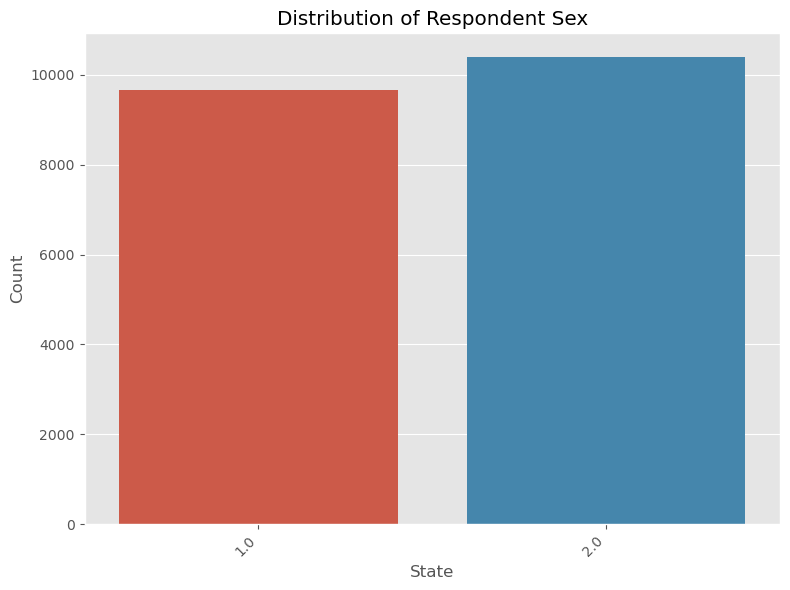

In [23]:
plt.style.use('ggplot')
plt.figure(figsize=(8, 6))
sns.countplot(x="SEXVAR", data=df4)
plt.title('Distribution of Respondent Sex')
plt.xlabel('State')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

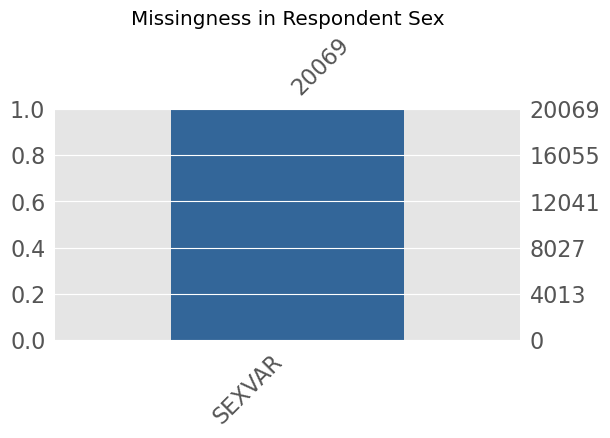

In [24]:
col = get_existing_cols(df2, sections, 'Respondent_Sex')
msno.bar(df2[col],
         figsize=(6, 3),
         color=(0.2, 0.4, 0.6)
)
plt.title("Missingness in Respondent Sex")
plt.show()

### Rural vs Urban Demographic

1 = Urban,  2 = Rural. Significantly more representation by Rural.

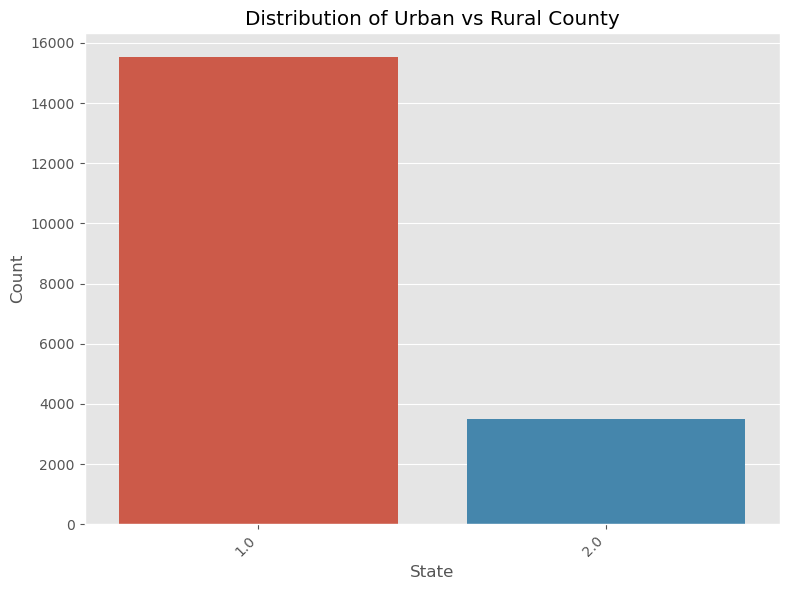

In [25]:
plt.style.use('ggplot')
plt.figure(figsize=(8, 6))
sns.countplot(x="_URBSTAT", data=df4)
plt.title('Distribution of Urban vs Rural County')
plt.xlabel('State')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

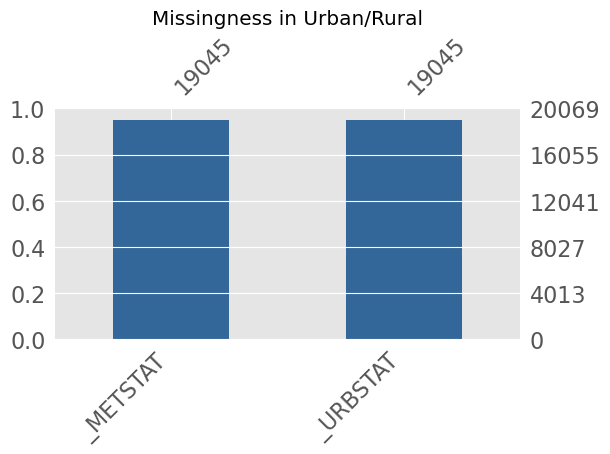

In [26]:
col = get_existing_cols(df2, sections, 'Urban_Rural')
msno.bar(df2[col],
         figsize=(6, 3),
         color=(0.2, 0.4, 0.6)
)
plt.title("Missingness in Urban/Rural")
plt.show()

### States represented

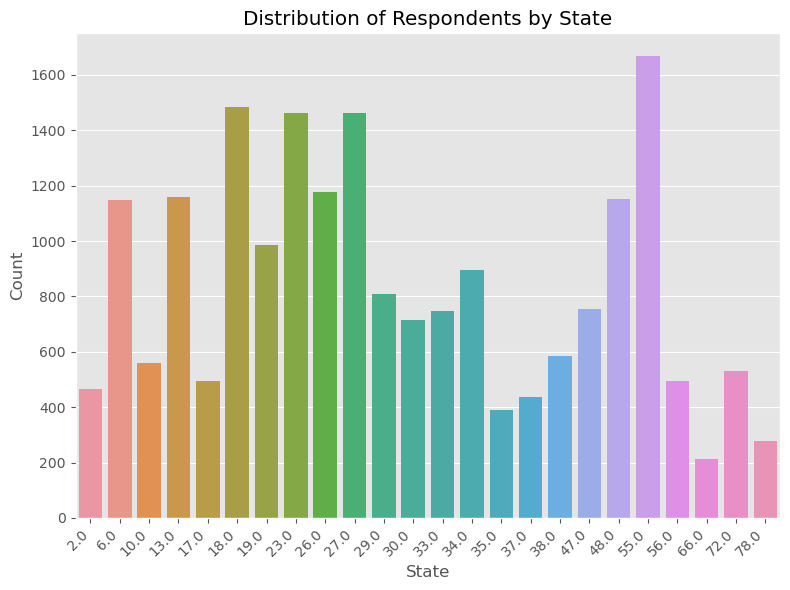

In [27]:
plt.style.use('ggplot')
plt.figure(figsize=(8, 6))
sns.countplot(x= "_STATE", data=df4)
plt.title('Distribution of Respondents by State')
plt.xlabel('State')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


State information is not meaningful in current display and will have to be re-coded. Highest state represented is 55 which is Wisconson. This is not representative of population samples within the United States. For example California (6.0) representation is significantly lower and New York (36) is not represented.

### Tobacco Use

In [28]:
#Data quality report
filter = get_existing_cols(df4, sections, 'Tobacco_Use')
df_sample = df4[filter]
dq_tobacco_use = dqr(df4, filter)
dq_tobacco_use

,Feature,Count,Missing Values,Cardinality,Min,1st Quartile,Mean,Median,3rd Quartile,Max,Std Dev
0,SMOKE100,19336,733,4,1.0,1.0,1.584868,2.0,2.0,9.0,0.700834
1,SMOKDAY2,8771,11298,5,1.0,3.0,2.617033,3.0,3.0,9.0,0.794982
2,USENOW3,19311,758,5,1.0,3.0,2.970224,3.0,3.0,9.0,0.337373
3,ECIGNOW2,19281,788,6,1.0,1.0,1.486593,1.0,1.0,9.0,1.142511


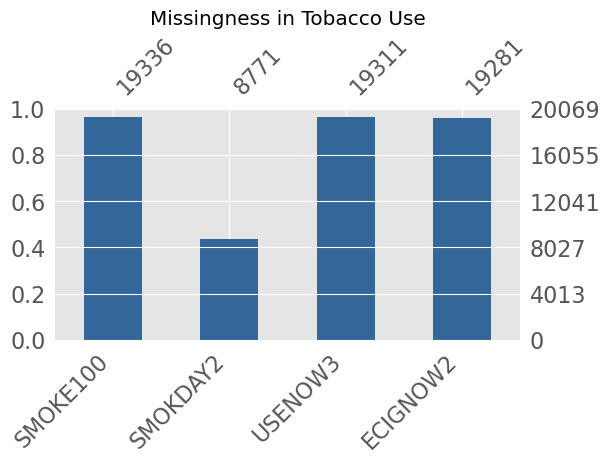

In [29]:
col = get_existing_cols(df2, sections, 'Tobacco_Use')
msno.bar(df2[col],
         figsize=(6, 3),
         color=(0.2, 0.4, 0.6)
)
plt.title("Missingness in Tobacco Use")
plt.show()

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


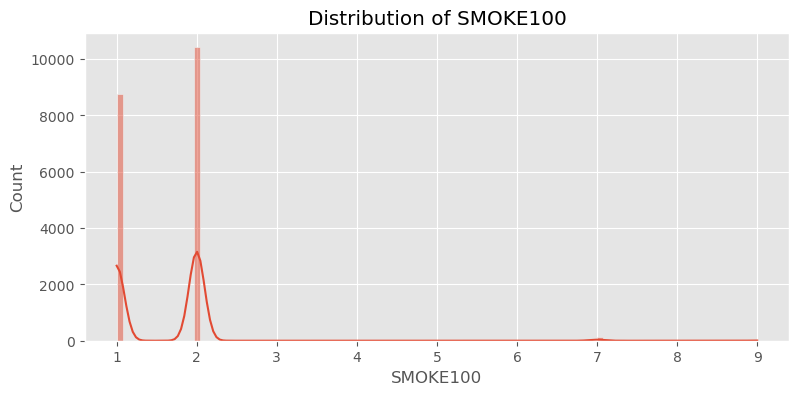

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


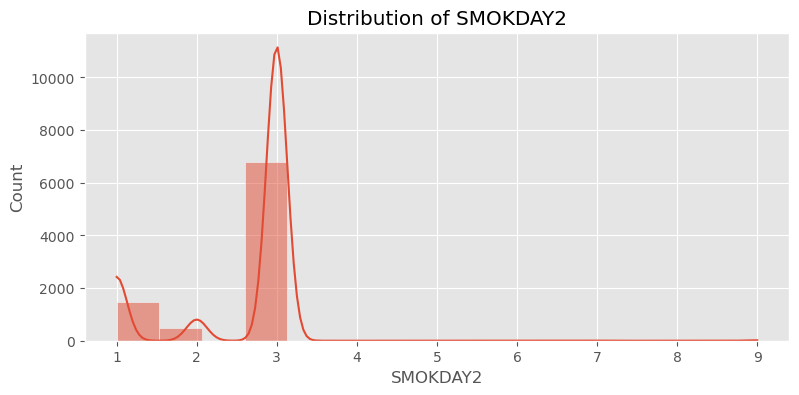

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


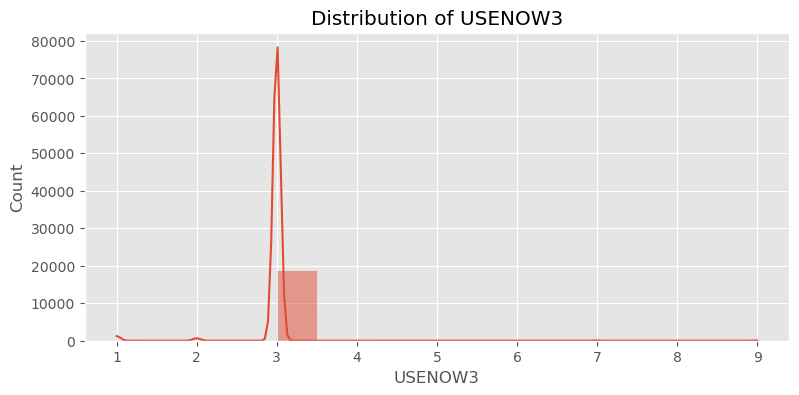

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


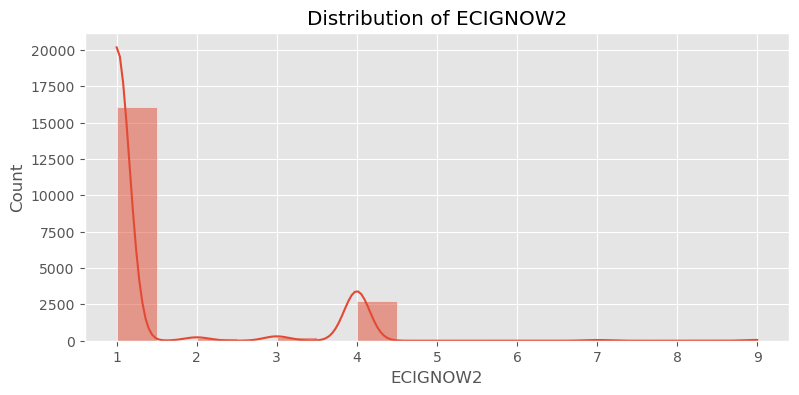

In [30]:
plt.style.use('ggplot')
for column in filter:
    plt.figure(figsize=(20, 4))
    plt.subplot(1, 2, 1)
    sns.histplot(df4[column], kde = True)
    plt.title(f'Distribution of {column}')
    plt.show()

### Demographics

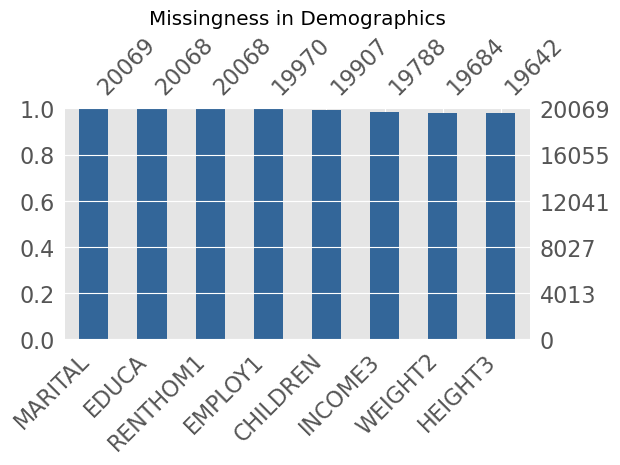

In [31]:

col = get_existing_cols(df4, sections, 'Demographics')
msno.bar(df2[col],
         figsize=(6, 3),
         color=(0.2, 0.4, 0.6)
)
plt.title("Missingness in Demographics")
plt.show()

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


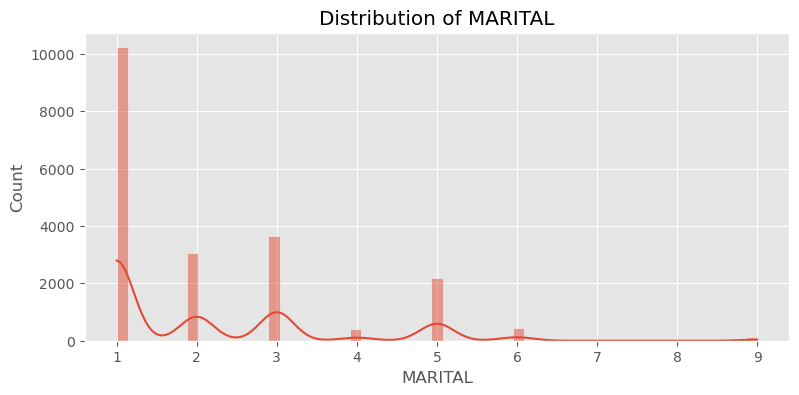

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


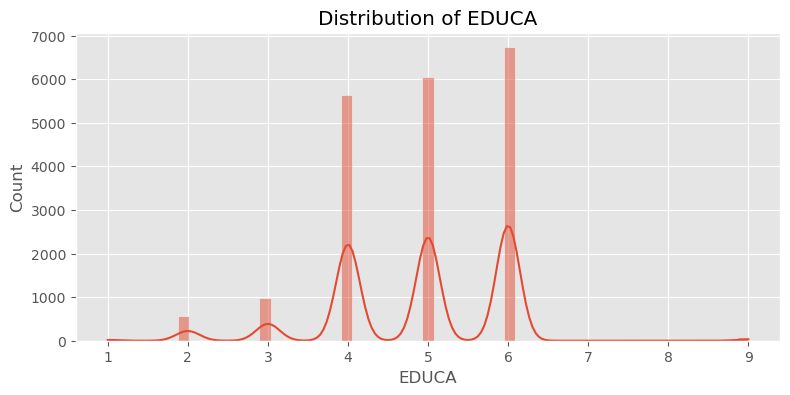

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


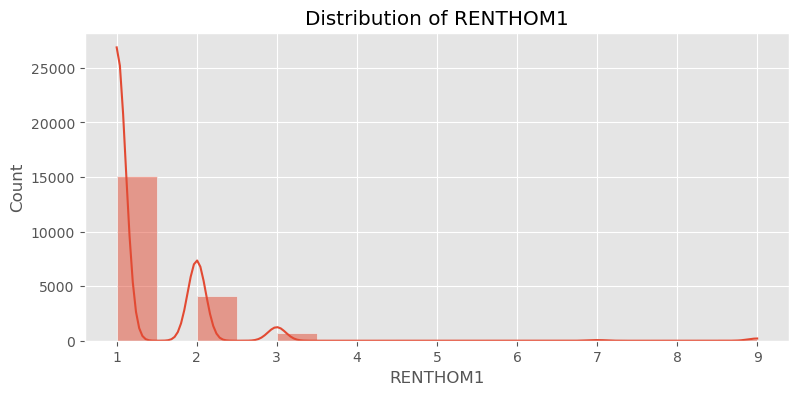

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


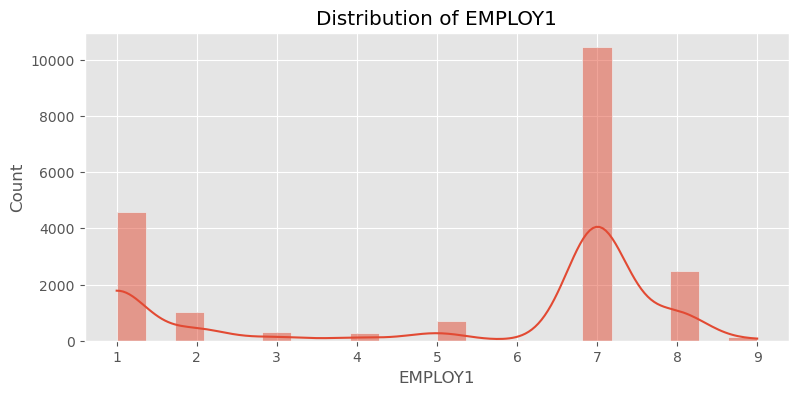

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


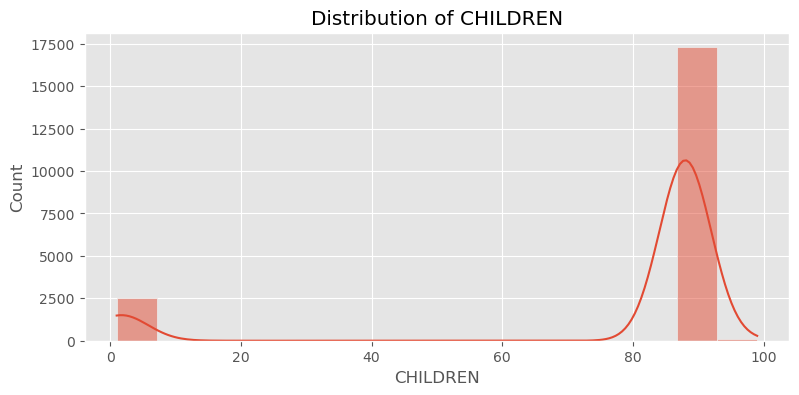

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


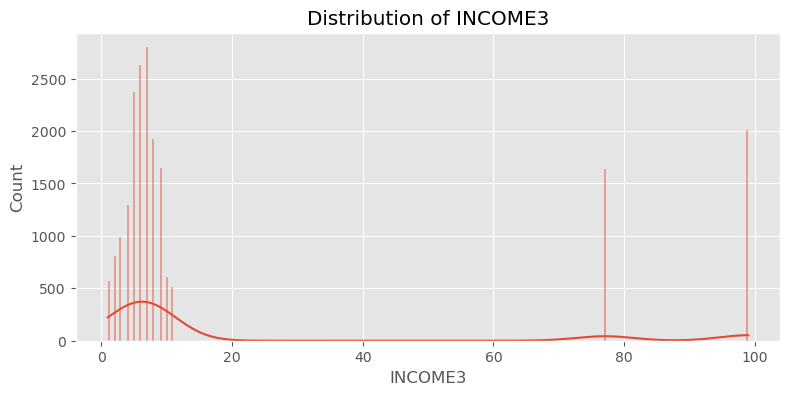

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


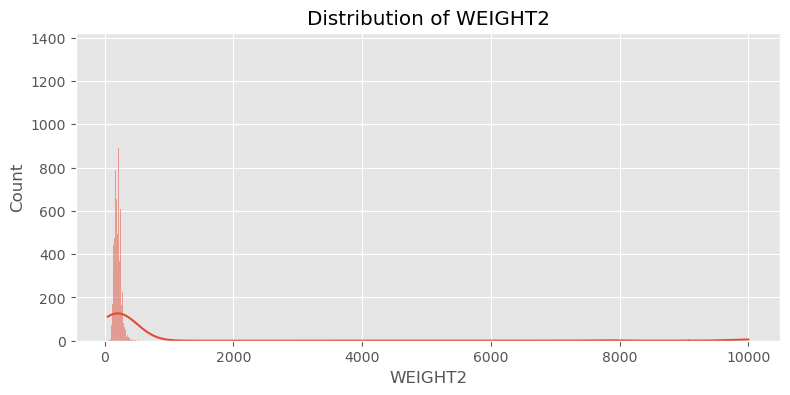

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


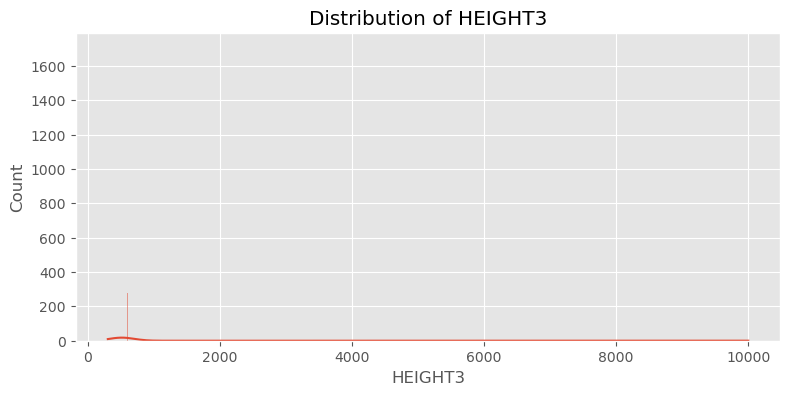

In [32]:
dem_filter = get_existing_cols(df4, sections, 'Demographics')
plt.style.use('ggplot')
for column in dem_filter:
    plt.figure(figsize=(20, 4))
    plt.subplot(1, 2, 1)
    sns.histplot(df4[column], kde = True)
    plt.title(f'Distribution of {column}')
    plt.show()

Children look odd because 88 = "none" and 99 = "Refused".

In [33]:
#dataquality report

dq_demographics = dqr(df4, dem_filter)
dq_demographics

,Feature,Count,Missing Values,Cardinality,Min,1st Quartile,Mean,Median,3rd Quartile,Max,Std Dev
0,MARITAL,20069,0,7,1.0,1.0,2.167622,1.0,3.0,9.0,1.540920
1,EDUCA,20068,1,7,1.0,4.0,4.878114,5.0,6.0,9.0,1.071609
2,RENTHOM1,20068,1,5,1.0,1.0,1.331025,1.0,1.0,9.0,0.812397
3,EMPLOY1,19970,99,9,1.0,2.0,5.324387,7.0,7.0,9.0,2.724599
4,CHILDREN,19907,162,14,1.0,88.0,77.089114,88.0,88.0,99.0,28.755302
5,INCOME3,19788,281,13,1.0,5.0,21.433899,7.0,9.0,99.0,32.565923
6,WEIGHT2,19684,385,375,50.0,170.0,732.902357,200.0,240.0,9999.0,2159.071853
7,HEIGHT3,19642,427,80,305.0,504.0,727.078760,507.0,510.0,9999.0,1336.790926


## Feature Engineering Recommendations

1. 'Chronic_Health_Conditions'  and 'needs to be converted into a Diabetes Co-morbidity Score. Something that would score how severe their comorbidities are.
2. We should have a Diabetic Care score from the 'Diabetes' section.
3. We should create a disability indicator from the "disability" section.
4. We should create some sort of score from COVID Vacccination, Immunixation, HPV_Vaccination, Tetanus & Healthcare_Access. Basically indicating if they have the ability to get proactive care or are actively getting proactive care.
5. Drinking & driving (Seatbelt use/drinking and driving) and Alcohol should be combined to create some sort of alcohol abuse indicator.
6. Height & Weight should be combined for a BMI indicator. See Note below about weight & height

*All other sections remaining but not mentioned, we should consider combining  within that section to create some sort of indicator*

**WEIGHT**
See image below explaining how the weight feature works. We would need to do some cleaning before BMI conversion.

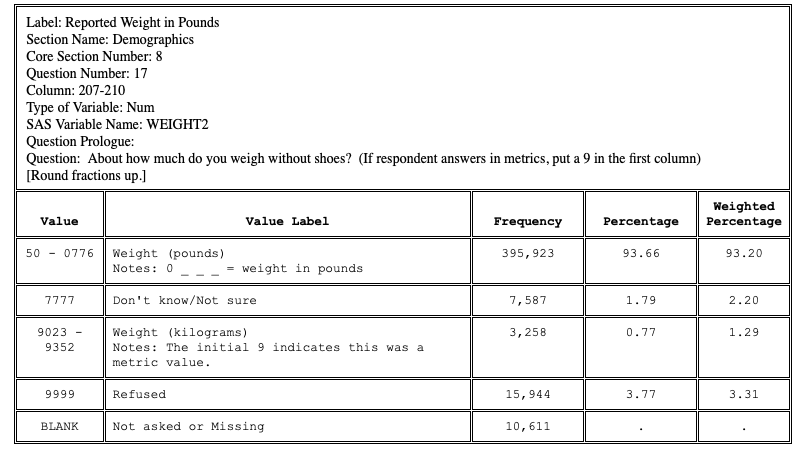

HEIGHT

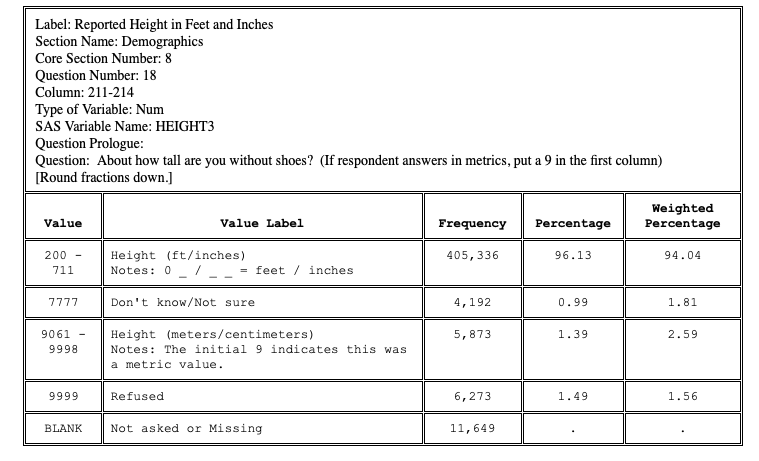